Connecting to Augur

In [1]:
import pandas as pd
import json
import sqlalchemy as salc
import psycopg2

with open("../config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
                              config['user'],
                              config['password'],
                              config['host'],
                              config['port'],
                              config['database']
                            )

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Activity Metrics
- SQL query for github activity metrics
- Focused on the increment in activity (star/fork/watch/committer/commit/issue) over time to prevent from old repo having lots of accumulated activity.
    -  Assigned different weights for #increase_in_stars, #increase_in_forks, #increase_in_watch, #increase_in_committer, #increase_in_commit, #increase_in_issue, #increase_in_pr, #increase_in_pr_open, #increase_in_pr_close, #increase_in_pr_merge, then sum them together

In [16]:
dframe = pd.DataFrame()

repo_query = salc.sql.text(f"""
SELECT x.repo_id,
       x.rg_name,
       x.repo_name,
       last_updated,
       DATE(last_updated),
       to_char(last_updated, 'DAY'),
       EXTRACT(year FROM last_updated) AS "Year",
       EXTRACT(month FROM last_updated) AS "month",
       extract(hour from last_updated) AS "hour",
       x.increase_committer,
       x.increase_pr_open,
       x.increase_commit,
       (x.increase_committer + x.increase_pr_open + x.increase_pr_close + x.increase_pr_merge + x.increase_issue + x.increase_pr + x.increase_star + x.increase_fork)*10 AS total
            FROM(
        SELECT 
            rg.repo_group_id,
            rg.rg_name,
            r.repo_id,
            r.repo_name,
            /*ri.license,*/
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.stars_count - lag(ri.stars_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 0.01
            END
                AS increase_star,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.fork_count - lag(ri.fork_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 0.5
            END
                AS increase_fork,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.watchers_count - lag(ri.watchers_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 0.8
            END
                AS increase_watch,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.committers_count - lag(ri.committers_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) *1.5
            END
                AS increase_committer,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.commit_count - lag(ri.commit_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.2
            END
                AS increase_commit,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.issues_count - lag(ri.issues_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.3
            END
                AS increase_issue,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_request_count - lag(ri.pull_request_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.6
            END
                AS increase_pr,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_requests_open - lag(ri.pull_requests_open) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.6
            END
                AS increase_pr_open,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_requests_closed - lag(ri.pull_requests_closed) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.8
            END
                AS increase_pr_close,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_requests_merged - lag(ri.pull_requests_merged) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 2    
            END
                AS increase_pr_merge,
            ri.last_updated,
            CASE
                WHEN EXTRACT(YEAR FROM ri.last_updated) < 2022 THEN 'far away'
                WHEN EXTRACT(YEAR FROM ri.last_updated) >= 2022 THEN 'recent'
            END
                AS segment,
            EXTRACT(year FROM last_updated) AS "Year",
            EXTRACT(month FROM last_updated) AS "month" 
        FROM REPO r
            LEFT JOIN repo_groups rg
            ON rg.repo_group_id = r.repo_group_id
            LEFT join repo_info ri 
            on r.repo_id = ri.repo_id 
        /*where rg.rg_name = 'agroal'*/
        order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) AS x
""")

In [109]:
dframe = pd.read_sql(repo_query, con=engine)
# extract specific org as sample dataset
# dtest = dframe[dframe['rg_name'] == 'fedora']

# calculating activeness percentage based on repo_name
dframe['percentage'] = dframe['total'] / dframe.groupby('repo_name')['total'].transform('sum')

# Fill NA value of specific column into zero
# dtest['percentage'] = dtest['percentage'].fillna(0)
# Fill all NA value into zero
dframe = dframe.fillna(0)

# get the first 500 rows as sample data
duse = dframe[:500]

# extract column 'month' and 'percentage', copy it as another dataframe
# dft = dtest[['month', 'percentage']].copy()
dft = duse['percentage'].copy()

In [110]:
dframe.head()

,repo_id,rg_name,repo_name,last_updated,date,to_char,Year,month,hour,increase_committer,increase_pr_open,increase_commit,total,percentage
0,24441,Default Repo Group,operate-first-twitter,2021-10-12 09:19:15,2021-10-12,TUESDAY,2021.0,10.0,9.0,0.0,0.0,0.0,0.0,0.000000
1,24441,Default Repo Group,operate-first-twitter,2021-10-12 09:19:15,2021-10-12,TUESDAY,2021.0,10.0,9.0,0.0,0.0,0.0,0.0,0.000000
2,24441,Default Repo Group,operate-first-twitter,2021-10-26 18:15:41,2021-10-26,TUESDAY,2021.0,10.0,18.0,-15.0,-1.6,0.0,-146.0,-0.469453
3,24441,Default Repo Group,operate-first-twitter,2021-10-26 18:15:41,2021-10-26,TUESDAY,2021.0,10.0,18.0,0.0,0.0,0.0,0.0,0.000000
4,24441,Default Repo Group,operate-first-twitter,2021-10-26 18:15:41,2021-10-26,TUESDAY,2021.0,10.0,18.0,16.5,0.0,0.0,165.0,0.530547


## PR
SQL query for github performance metrics
- whether the PR is closed or open -> status
- time required to close an PR -> duration
- how many days has passed since the ticket is closed -> exp decay

In [4]:
dframe_pr = pd.DataFrame()

pr_query = salc.sql.text(f"""

SELECT repo_id,
		close_duration,
		exp_decay,
		count(pull_request_id) AS num,
		close_duration*exp_decay*count(pull_request_id) as total
		FROM(
			SELECT pull_request_id, repo_id,
				   pr_src_state,
				   (pr_closed_at - pr_created_at) AS pull_request_duration,
				   CASE 
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '30 days' THEN 1
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '60 days' THEN 0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '90 days' THEN 0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '120 days' THEN 0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '150 days' THEN 0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '180 days' THEN 0.8*0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '210 days' THEN 0.8*0.8*0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '240 days' THEN 0.8*0.8*0.8*0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '270 days' THEN 0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '300 days' THEN 0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '330 days' THEN 0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at < INTERVAL '360 days' THEN 0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8*0.8
				   	WHEN pull_requests.pr_closed_at IS NULL AND NOW() - pull_requests.pr_created_at < INTERVAL '45 days' THEN 0.5
				   	ELSE 0
				   END
				   AS close_duration,
				   NOW() - pull_requests.pr_closed_at AS "time_passed",
				   CASE 
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '30 days' THEN 1
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '60 days' THEN 0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '90 days' THEN 0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '120 days' THEN 0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '150 days' THEN 0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '180 days' THEN 0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '210 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '240 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '270 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '300 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '330 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '360 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	ELSE 0
				   END
				   AS exp_decay,
				   pull_requests.pr_closed_at
			FROM pull_requests
			WHERE EXTRACT(YEAR FROM pull_requests.pr_closed_at) >= 2022
			ORDER BY repo_id 
		) AS x
	GROUP BY repo_id, close_duration, exp_decay
	order by repo_id

""")

dframe_pr = pd.read_sql(pr_query, con=engine)

In [7]:
dframe_pr.head()

,repo_id,close_duration,exp_decay,num,total
0,25440,1.0,0.59049,3,1.77147
1,25458,1.0,0.59049,1,0.59049
2,25459,1.0,0.65610,28,18.37080
3,25459,1.0,0.59049,10,5.90490
4,25459,1.0,0.72900,37,26.97300


## Issue
- SQL query for github performance metrics
- time required to close an issue -> duration
- how many days has passed since the ticket is closed -> exp decay

In [5]:
issue_query = salc.sql.text(f"""
SELECT repo_id,
		close_duration,
		exp_decay,
		count(issue_id) AS num,
		close_duration*exp_decay*count(issue_id) AS total
		FROM(
			SELECT repo_id,
				   issue_id,
				   issue_state,
				   (closed_at - created_at) AS issue_close_duration,
				   /*(updated_at - created_at) as issue_update_duration,*/
				   CASE 
					   	WHEN i.closed_at - i.created_at < interval '15 days' THEN 1
					   	WHEN i.closed_at - i.created_at < interval '30 days' THEN 0.7
					   	WHEN i.closed_at - i.created_at < interval '60 days' THEN 0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '90 days' THEN 0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '120 days' THEN 0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '150 days' THEN 0.7*0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '180 days' THEN 0.7*0.7*0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '210 days' THEN 0.7*0.7*0.7*0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '240 days' THEN 0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '270 days' THEN 0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '300 days' THEN 0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '330 days' THEN 0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7
					   	WHEN i.closed_at - i.created_at < interval '360 days' THEN 0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7*0.7
					   	when i.closed_at IS NULL AND NOW() - i.created_at < interval '45 days' THEN 0.5
					   	ELSE 0
				   END
				   AS close_duration,
				   i.created_at,
				   i.closed_at,
				   NOW() - i.closed_at AS "time_passed_after_closing",
				   CASE 
				   	WHEN NOW() - i.closed_at < interval '30 days' THEN 1
				   	WHEN NOW() - i.closed_at < interval '60 days' THEN 0.9
				   	WHEN NOW() - i.closed_at < interval '90 days' THEN 0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '120 days' THEN 0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '150 days' THEN 0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '180 days' THEN 0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '210 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '240 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '270 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '300 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '330 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '360 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	ELSE 0
				   END
				   AS exp_decay
			FROM issues i
			WHERE extract(year from i.created_at) >= 2022
			ORDER BY repo_id
			) AS x
	GROUP BY repo_id, close_duration, exp_decay
	order by repo_id
""")

dframe_issue = pd.read_sql(issue_query, con=engine)

## Performance Metrics
- Evaluating the duration from issue open to close as issue_close_duration column
- Issue_close_duration_day column: extract day from issue_close_duration

In [98]:
issue2_query = salc.sql.text(f"""	
			SELECT repo_id,
				   issue_state,
				   (closed_at - created_at) AS issue_close_duration,
				   extract(day from closed_at - created_at) AS issue_close_duration_day,
				   comment_count
			FROM issues i
			WHERE extract(year from i.created_at) >= 2022
			ORDER BY repo_id
""")

dtest = pd.read_sql(issue2_query, con=engine)

In [99]:
dtest.head()

,repo_id,issue_state,issue_close_duration,issue_close_duration_day,comment_count
0,24441,closed,0 days 00:07:04,0.0,1
1,24441,closed,0 days 06:28:34,0.0,1
2,24441,closed,0 days 01:06:43,0.0,1
3,24441,closed,0 days 21:11:11,0.0,1
4,24441,closed,0 days 17:05:01,0.0,1


Extract only issue_close_duration_day and comment_count column from the original dataframe and make a copy

In [100]:
frame = dtest[['issue_close_duration_day', 'comment_count']].copy()
frame = frame.fillna(0)
frame.head()

,issue_close_duration_day,comment_count
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,1


## Elbow method...
Apply KMenas clustering on the duration_day and comment_count column for segmentation on issue being closed within how many days should be segmented into how many differenct groups, what are each decay rate...
- Number of clusters (n = 4): number of groups for different performance (active performance/ mild performance/ poor performance/ low performance)
- Cluster size (179995, 13545, 3011, 103): The threshold for the four groups?
- Decay rate (slope in the curve?): how much weight should be given to active performance? Mild performance? Poor performance? Low performance?

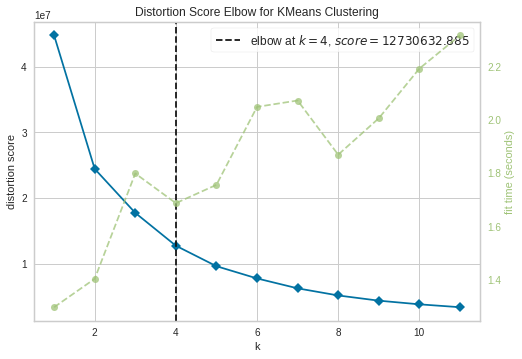

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [101]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(frame)
visualizer.show()

In [102]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(frame)

In [103]:
print(kmeans.labels_)
print(kmeans.inertia_)
print(kmeans.n_iter_)
print(kmeans.cluster_centers_)

[0 0 0 ... 0 0 0]
12730633.270213097
12
[[  1.14542313   2.05996933]
 [ 80.801727     2.925274  ]
 [ 18.04854369 258.90291262]
 [ 24.74977857   6.18024801]]


k-means clustering has four clusters of size 179995, 13545, 3011, and 103, which in our case menas that there's 179995 active performance, 13545 mild performace, and 3011 poor performance...

In [105]:
from collections import Counter
Counter(kmeans.labels_)

Counter({0: 179995, 3: 13545, 1: 3011, 2: 103})

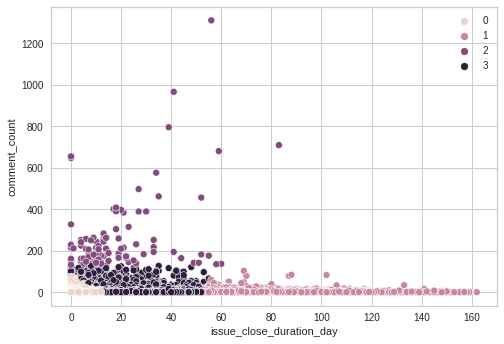

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=frame, x="issue_close_duration_day", y="comment_count", hue=kmeans.labels_)
plt.show()

Question: I used commnet count as y axis, but not sure if that make sense at all

## Activity plot (WIP)

In [40]:
# Plot...
import plotly.express as px
import pandas as pd
dframe = dframe[:1000]

fig = px.imshow(dframe, color_continuous_scale=px.colors.sequential.Purples,
                title="Github activity")
fig.update_layout(title_font={'size':27}, title_x=0.5)
fig.update_traces(hoverongaps=False,
                  hovertemplate="rg_name: %{y}"
                                "<br>Date: %{x}"
                                "<br>percentage %: %{z}<extra></extra>"
                  )

## heatmap with dash (WIP)

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
external_stylesheets = 'https://codepen.io/chriddyp/pen/bWLwgP.css'

input_data = duse
data = []
week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
for i in week:
    for j in range(24):
        data.append([i,j])
check = pd.DataFrame(data,columns=['date','hour'])

org = dframe['rg_name'].unique()
repo = dframe['repo_name'].unique()
org_default = dframe['rg_name'][0]
repo_default = dframe['repo_name'][0]
df_default = dframe[(dframe['rg_name'] == org_default) & (dframe['repo_name'] == repo_default)]

app.layout = html.Div([
                html.H1('Github Analysis'),
                html.Div([
                html.Div([
                html.H4('Select org'),

                dcc.Dropdown(
                    id='org_dropdown',
                    multi=True,
                    options=[{'label': i, 'value': i} for i in org],
                    value = org_default
                    ),
                    ],
                    style={'width': '48%', 'display': 'inline-block'}),

                html.Div([
                html.H4('Select repo'),

                dcc.Dropdown(
                    id='repo_dropdown',
                    multi=True,
                    options=[{'label': i, 'value': i} for i in repo],
                    value = repo_default
                    ),
                    ],
                    style={'width': '48%', 'float': 'right', 'display': 'inline-block'}),

                dcc.Graph(id='heatmap', 
                    figure = {'data': [go.Heatmap(
                                x = df_default['date'],
                                y = df_default['hour'],
                                z = df_default['percentage'],
                                name = 'first legend group',
                                colorscale = 'Viridis')],
                            'layout': go.Layout(
                                xaxis = dict(title = 'Weekday'),
                                yaxis = dict( title = 'Hours'),
                            )})
                    ]),
                ])


@app.callback(
    dash.dependencies.Output(component_id = 'repo_dropdown', component_property='options'),
    [dash.dependencies.Input(component_id = 'org_dropdown', component_property='value')]
)
def update_Menu_dropdown(selected_POS):
    return [{'label': i, 'value': i} for i in dframe[dframe['rg_name'] == selected_POS]['repo_name'].unique()]


def update_graph(org_dropdown,repo_dropdown):
    heatmap_data = dframe[(dframe['rg_name'] == org_dropdown) & (dframe['repo_name'] == repo_dropdown)][['date','hour','percentage']]
    heatmap_data = pd.merge(dframe, heatmap, check, on=['date', 'hour'],how='outer').fillna(0)
    print (org_dropdown,repo_dropdown)
    maxsale = heatmap_data[heatmap_data['percentage'] == heatmap_data['percentage'].max()]
    maxsale = maxsale.reset_index()

    return {
    'data': [go.Heatmap(
        x = heatmap_data['date'],
        y = heatmap_data['hour'],
        z = heatmap_data['percentage'],
        xgap = 2,
        ygap = 2,
        colorscale = 'Viridis')],
    'layout': go.Layout(
        title = 'MAJORITY OF ' + repo_dropdown + ' SOLD AT ' + str.upper(org_dropdown) + ' IS ON ' + str.upper(maxsale['date'][0]) + ' ' + str(maxsale['hour'][0])
    )
    }


if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False, port=8051)